In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt

import util

In [3]:
dsets = util.open_cmip_cached(
    operator_applied="regional_integral", 
    region_mask="SET_NET",
)
ds = dsets['historical.Omon.SET_NET.regional_integral']
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.table_id.region_mask.operator_applied'


<xarray.Dataset>
Dimensions:       (source_id: 12, region: 2, month: 12)
Coordinates:
  * source_id     (source_id) <U15 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1-0-LL'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) <U3 'NET' 'SET'
Data variables:
    epc100        (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fbddtdic      (source_id, region, month) float32 dask.array<chunksize=(4, 2, 12), meta=np.ndarray>
    fgapo         (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgco2         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgn2          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgo2          (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgo2_thermal  (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    hfds          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    intpp         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    sos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    tos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
Attributes:
    intake_esm_varname:      epc100\nfbddtdic\nfgapo\nfgco2\nfgn2\nfgo2\nfgo2...
    intake_esm_dataset_key:  historical.Omon.SET_NET.regional_integral

## Make some plots

In [4]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

In [5]:
# define function to plot 4 variables (columns) by 2 regions (rows)

def plot4var2reg(variable_ids):

    nrows = 2
    ncols = len(variable_ids)
    
    #ncols = 4
    #nrows = np.ceil(len(variable_ids)*len(ds.region.values)/ncols).astype(int)
    #for region, field, ax in zip(np.repeat(ds.region.values,len(variable_ids)), variable_ids*len(ds.region.values), axs.ravel()):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) # , sharey=True)

    for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
        for counter,source_id in enumerate(ds.source_id.values):
            if counter < 10:
                mk='o'
            else:
                mk='x'
            ax.plot(
                ds.month-0.5, 
                ds[field].sel(source_id=source_id, region=region), 
                marker=mk, 
                linestyle='-',
                label=source_id,
            )

        ax.set_xticks(np.arange(13))    
        ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
        ax.set_title(region);
        ax.set_xticklabels([])
        ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
    ax.legend(loc=(1.02, 0));

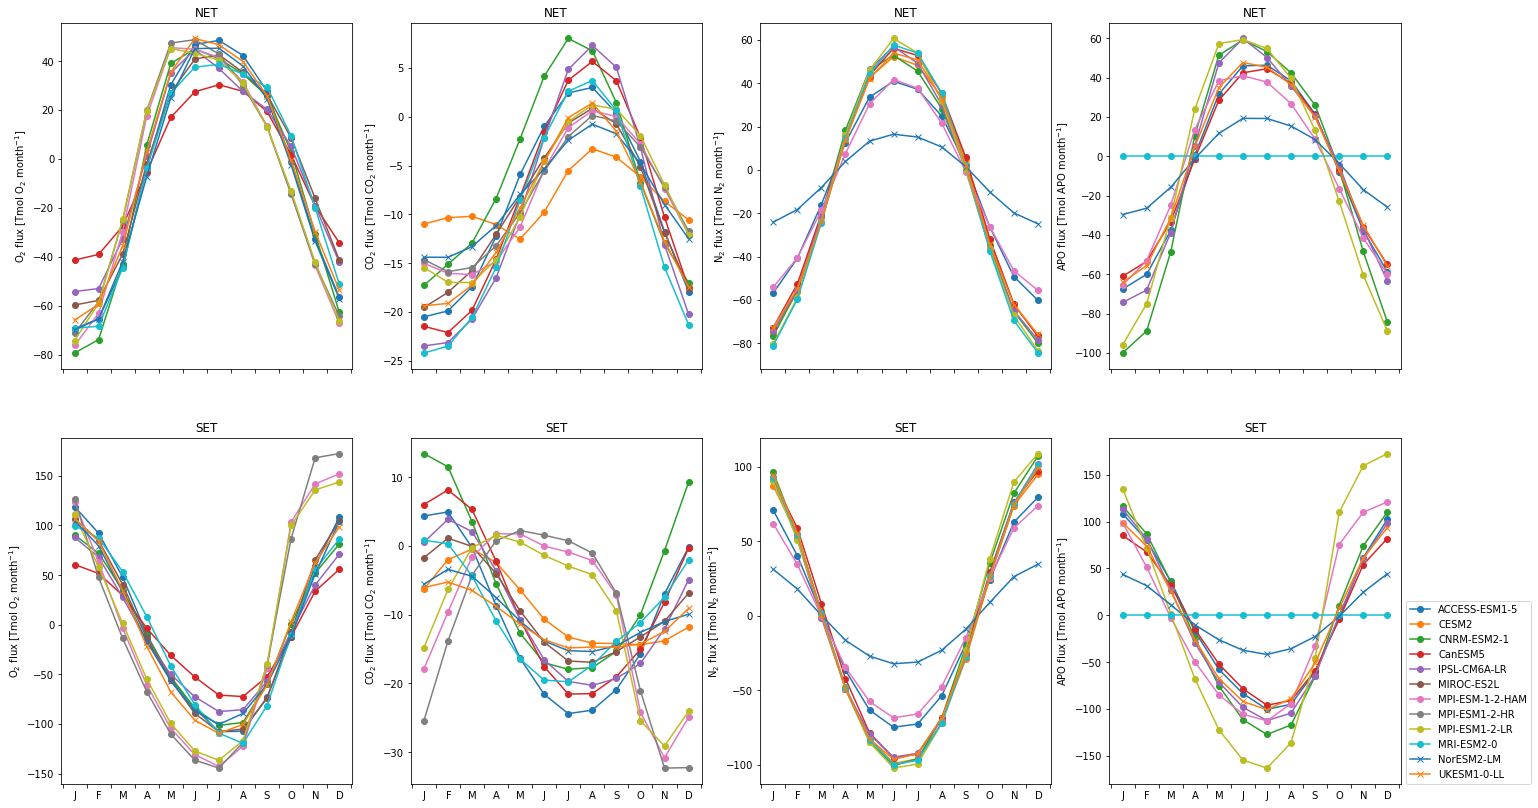

In [6]:
variable_ids = ['fgo2','fgco2','fgn2','fgapo']
plot4var2reg(variable_ids)

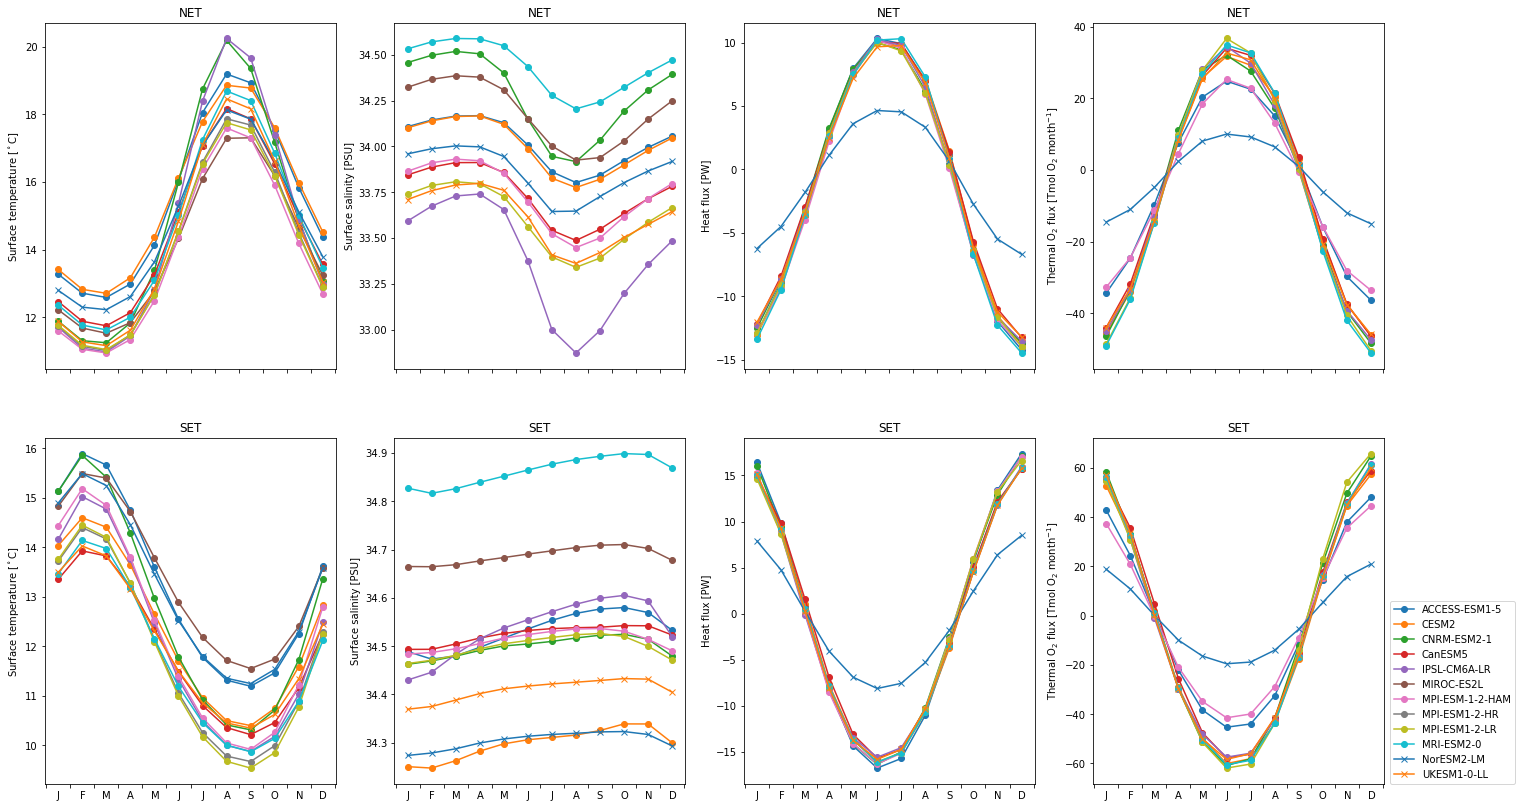

In [7]:
variable_ids = [ 'tos', 'sos', 'hfds','fgo2_thermal' ]
plot4var2reg(variable_ids)

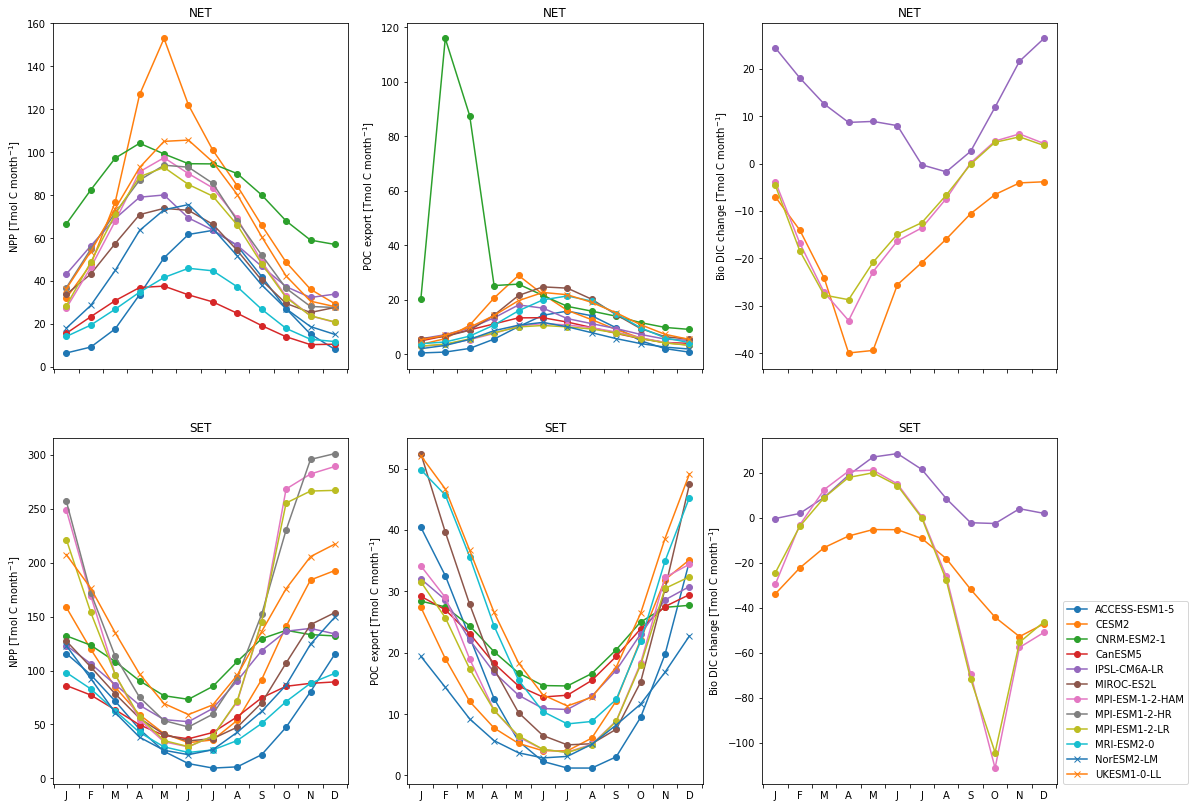

In [8]:
variable_ids = [ 'intpp', 'epc100', 'fbddtdic']
plot4var2reg(variable_ids)

## Test SNO calculations

In [9]:
# defining SNO here as the seasonal component of the O2 (or APO for SNOapo) flux
# specifically the integral of positive flux values after subtracting the annual mean
# (or the amplitude of the time-integrated flux cycle)
# this is to match the observed APO cycle in the atmosphere which has an arbitrary mean (i.e. it is agnostic to annual mean fluxes)

source_id='CanESM5'
region='SET'

# first remove the annual mean
ds['fgaposeas'] = ds['fgapo'].sel(source_id=source_id, region=region)-ds['fgapo'].sel(source_id=source_id, region=region).mean()

# then sum positive values
ds['sno']=sum(x for x in ds['fgaposeas'] if x > 0)
ds['sno'].values

array(353.8326, dtype=float32)

In [10]:
# alternately calculate time integral

ds['fgapoint'] = ds['fgaposeas'].cumsum()
# then find the amplitude
ds['sno'] = ds['fgapoint'].max() - ds['fgapoint'].min()
ds['sno'].values

array(353.83264, dtype=float32)

In [11]:
# get a slightly different value if we interpolate to daily resolution first

tmp=np.interp(np.arange(0,366)/365*12,ds['fgaposeas'].month-0.5,ds['fgaposeas'],period=12)
sum(x for x in tmp if x > 0)*12/365

352.4310716850866

## Calculate SNO and productivity metrics for all models

In [12]:
# loop through models and combine into a dataarray
#  - using daily interpolation as likely more accurate and better matches atmospheric data processing

for region in ds.region.values:
    for source_id in ds.source_id.values:
        #ds['fgo2seas'] = ds['fgo2'].sel(source_id=source_id, region=region) - ds['fgo2'].sel(source_id=source_id, region=region).mean()
        #daily_flux=np.interp(np.arange(0,366)/365*12,ds['fgo2seas'].month-0.5,ds['fgo2seas'],period=12)
        ds['fgaposeas'] = ds['fgapo'].sel(source_id=source_id, region=region) - ds['fgapo'].sel(source_id=source_id, region=region).mean()
        daily_flux=np.interp(np.arange(0,366)/365*12,ds['fgaposeas'].month-0.5,ds['fgaposeas'],period=12)
        print(source_id,region,sum(x for x in daily_flux if x > 0)*12/365)
            
# also calculate annual mean and seasonal amplitude of intpp, epc100, and fbddtdic

ACCESS-ESM1-5 NET 223.60966361580023
CESM2 NET 0.0
CNRM-ESM2-1 NET 305.43921462500145
CanESM5 NET 206.63245175377918
IPSL-CM6A-LR NET 248.89959498103548
MIROC-ES2L NET 0.0
MPI-ESM-1-2-HAM NET 206.1239046822303
MPI-ESM1-2-HR NET 0.0
MPI-ESM1-2-LR NET 300.7368429507018
MRI-ESM2-0 NET 0.0
NorESM2-LM NET 94.57607442191188
UKESM1-0-LL NET 214.46544370139068
ACCESS-ESM1-5 SET 398.4225152790329
CESM2 SET 0.0
CNRM-ESM2-1 SET 468.119308352335
CanESM5 SET 352.4310716850866
IPSL-CM6A-LR SET 423.965748306406
MIROC-ES2L SET 0.0
MPI-ESM-1-2-HAM SET 460.1844098854816
MPI-ESM1-2-HR SET 0.0
MPI-ESM1-2-LR SET 657.6248940074088
MRI-ESM2-0 SET 0.0
NorESM2-LM SET 162.79484952201494
UKESM1-0-LL SET 385.4887691538323


In [13]:
ds.fgapo.sel(source_id='MIROC-ES2L',region='SET').values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)